<a href="https://colab.research.google.com/github/jgabrielg99/Python/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
import random


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential, Model                                            # Importing the sequential module to define a sequential model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer                                                 # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Uncomment and run the below code if you are using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images = np.load('/content/drive/MyDrive/AIML Course/Files/images.npy')

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/AIML Course/Files/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [ ]:
images.shape

(4750, 128, 128, 3)

* There are 4750 images in this dataset
  * The dimensions of each images are 128x128 pixels
  * These are colored images, so there are 3 channels for each image (RGB)

In [ ]:
labels.shape

(4750, 1)

* Each image is labeled, so there are the same number of labels as there are images

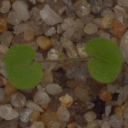

In [ ]:
cv2_imshow(images[0])

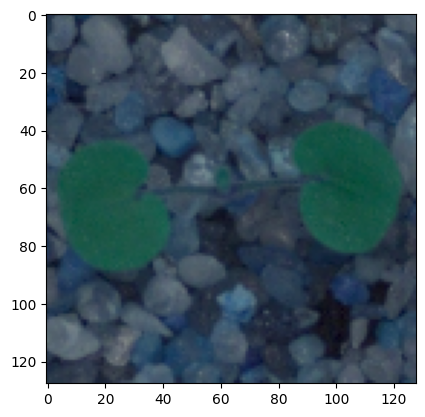

In [ ]:
plt.imshow(images[0])

In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

* The images are now all converted to RBG
  * As we can see, OpenCV reads images as BGR while matplotlib reads images as RGB
  * Converting the images to RGB will help to more easily interpret each image

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [ ]:
# function to display images from different categories
def plot_images(images, labels):
  num_classes=len(np.unique(labels))
  categories=np.unique(labels)
  keys=dict(labels['Label'])
  rows=3
  cols=4
  fig=plt.figure(figsize=(10,8))
  for i in range(cols):
    for j in range(rows):
      random_index=np.random.randint(0, len(labels))
      ax=fig.add_subplot(rows, cols, i*rows+j+1)
      ax.imshow(images[random_index, :])
      ax.set_title(keys[random_index])
  plt.show

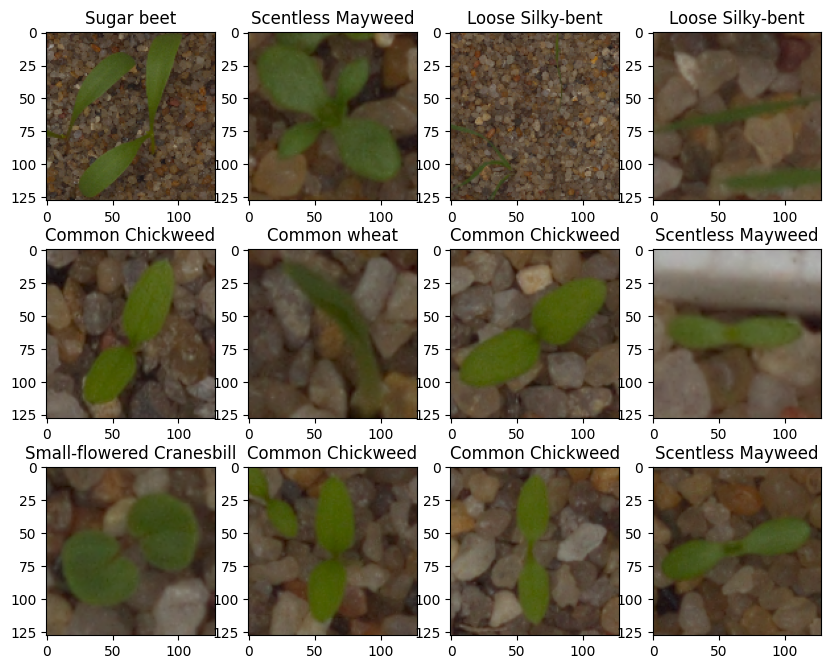

In [ ]:
plot_images(images, labels)

As we can see, the background of each of the images appears to be very similar. Some images appear to be more zoomed in than others as well, so applying data augmentation techniques will likely help our model by creating

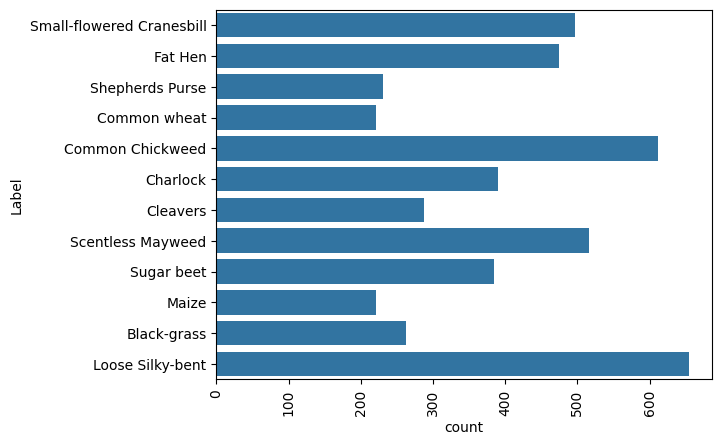

In [ ]:
sns.countplot(labels['Label'])
plt.xticks(rotation=90);

* The dataset is somewhat imbalanced. Some plant types have 600+ images while some types has less than 300.
  * Data augmentation will help with this imbalance

## Data Pre-Processing

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_resized = []
height=64
width=64
dimensions=(width,height)
for i in range(len(images)):
  images_resized.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

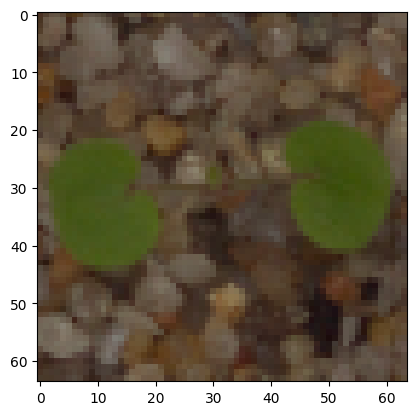

In [ ]:
plt.imshow(images_resized[0])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
X_big, X_test, y_big, y_test = train_test_split(np.array(images_resized), labels, test_size=0.1, random_state=1, stratify=labels)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_big, y_big, test_size=0.1, random_state=1, stratify=y_big)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


* The data is now split into a training set, validation set, and test set

### Encode the target labels

In [ ]:
enc = LabelBinarizer()
y_train_enc = enc.fit_transform(y_train)
y_val_enc = enc.transform(y_val)
y_test_enc = enc.transform(y_test)

In [ ]:
class_names = enc.classes_
pd.DataFrame(class_names, columns=['Class Names'])

,Class Names
0,Black-grass
1,Charlock
2,Cleavers
3,Common Chickweed
4,Common wheat
5,Fat Hen
6,Loose Silky-bent
7,Maize
8,Scentless Mayweed
9,Shepherds Purse


* Each of labels are now encoded as categorical values and are ready to be applied to our models

### Data Normalization

In [ ]:
X_train_norm = X_train.astype('float32')/255.0
X_val_norm = X_val.astype('float32')/255.0
X_test_norm = X_test.astype('float32')/255.0

* Normalizing the data simplifies our model by converting all of the values of each pixel into a range from 0-1 rather than 0-255

## Model Building

### CNN Model

In [ ]:
backend.clear_session()

In [ ]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

* Backend has been cleared and random seed it set to avoid consistent performance of our model

In [ ]:
# creates a sequential neural network model
model = Sequential()

# convolution layer with 64 filters, 3x3 kernel size, padding 'same' so the output shape matches input shape
# input_shape is dimensions of the images after resizing
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))

# max pooling layer to reduce size of output
model.add(MaxPooling2D((2, 2), padding='same'))

# additional convolution block to improve feature maps
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

# flattening layer to convert 2x2 images to 1 dimensional array
model.add(Flatten())

# adding fully connected dense layers with 32 neurons
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# output layers with 12 neurons for 12 possible classes, softmax activation function
model.add(Dense(12, activation='softmax'))

# using Adam Optimizer
opt=Adam()

# compile model
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# generate model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                2

In [ ]:
history_1 = model.fit(
    X_train_norm,
    y_train_enc,
    epochs=50,
    batch_size=32,
    verbose=2,
    validation_data=(X_val_norm, y_val_enc)
)

Epoch 1/50
121/121 - 12s - loss: 2.4023 - accuracy: 0.1593 - val_loss: 2.1253 - val_accuracy: 0.3528 - 12s/epoch - 99ms/step
Epoch 2/50
121/121 - 2s - loss: 1.9210 - accuracy: 0.3465 - val_loss: 1.6420 - val_accuracy: 0.4416 - 2s/epoch - 17ms/step
Epoch 3/50
121/121 - 2s - loss: 1.6171 - accuracy: 0.4357 - val_loss: 1.3649 - val_accuracy: 0.5771 - 2s/epoch - 14ms/step
Epoch 4/50
121/121 - 1s - loss: 1.4320 - accuracy: 0.4942 - val_loss: 1.2370 - val_accuracy: 0.6238 - 1s/epoch - 10ms/step
Epoch 5/50
121/121 - 1s - loss: 1.3337 - accuracy: 0.5308 - val_loss: 1.2067 - val_accuracy: 0.6379 - 1s/epoch - 10ms/step
Epoch 6/50
121/121 - 1s - loss: 1.2290 - accuracy: 0.5698 - val_loss: 1.2387 - val_accuracy: 0.6121 - 1s/epoch - 10ms/step
Epoch 7/50
121/121 - 1s - loss: 1.1750 - accuracy: 0.5854 - val_loss: 1.0921 - val_accuracy: 0.6659 - 1s/epoch - 9ms/step
Epoch 8/50
121/121 - 1s - loss: 1.0907 - accuracy: 0.6116 - val_loss: 1.0789 - val_accuracy: 0.6612 - 1s/epoch - 10ms/step
Epoch 9/50
121/

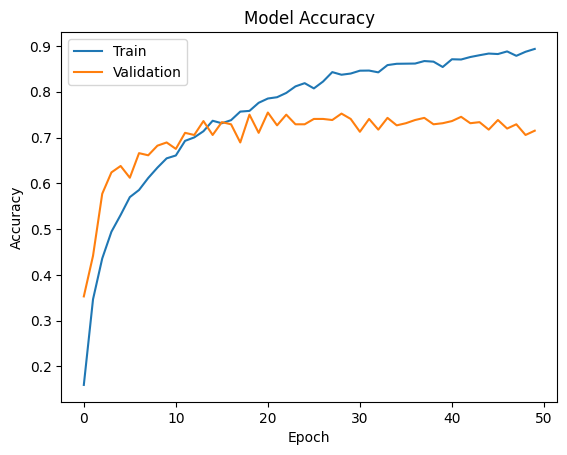

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* The accuracy of the training data comes in around .89 and the accuracy of the validation data is around .72
  * This does imply that there may be a bit of overfitting as the gap between training and validation is .17
  * We can address this via adding more dropout or adding in a BatchNormalization layer

In [ ]:
accuracy_1 = model.evaluate(X_test_norm, y_test_enc, verbose=2)

15/15 - 0s - loss: 1.7248 - accuracy: 0.6905 - 166ms/epoch - 11ms/step


* Testing data is also coming in around .69

In [ ]:
y_pred = model.predict(X_test_norm)

15/15 [==============================] - 0s 3ms/step


In [ ]:
y_pred

array([[1.8484601e-10, 3.5594590e-15, 1.5882107e-10, ..., 1.9630367e-08,
        2.2261985e-02, 9.0988442e-07],
       [3.6801125e-18, 2.9706448e-02, 4.4835786e-05, ..., 8.8104047e-03,
        9.6128410e-01, 6.0328133e-05],
       [4.9450025e-15, 1.8885020e-16, 1.8186089e-16, ..., 2.0712838e-08,
        4.1721297e-12, 7.4485837e-07],
       ...,
       [4.3488640e-08, 4.1661939e-01, 4.1226581e-01, ..., 1.5454584e-02,
        1.6270028e-02, 1.1826407e-01],
       [1.1395486e-33, 1.7470261e-21, 6.5253361e-25, ..., 4.5393099e-07,
        6.1696100e-17, 3.0006997e-12],
       [8.5422192e-03, 4.1556115e-05, 1.0539478e-03, ..., 7.6019479e-04,
        7.9277961e-06, 5.8200061e-01]], dtype=float32)

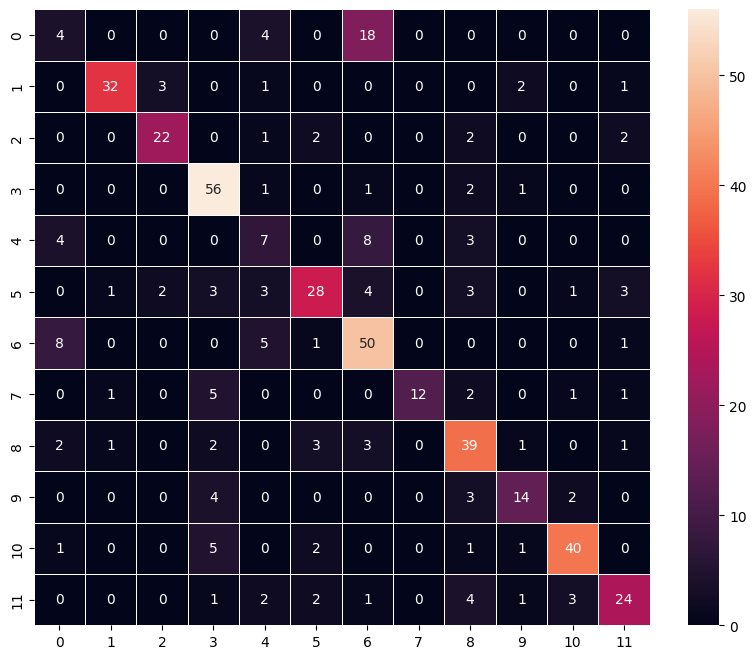

In [ ]:
y_pred_arg=np.argmax(y_pred, axis=1)
y_test_arg=np.argmax(y_test_enc, axis=1)

confusion_matrix=tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt='d',
    square=True,
    ax=ax
)
plt.show()

* As we can see, a large number of the images in the testing data were correctly classified; however, there were some categories that the model struggled to identify
  * For example, 18 image from class 6 were wrongly identified as class 0

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    fill_mode='nearest'
)

In [ ]:
# creates a sequential neural network model
model_2 = Sequential()

# convolution layer with 64 filters, 3x3 kernel size, padding 'same' so the output shape matches input shape
# input_shape is dimensions of the images after resizing
model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))

# max pooling layer to reduce size of output
model_2.add(MaxPooling2D((2, 2), padding='same'))

# additional convolution block to improve feature maps
model_2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2, 2), padding='same'))
model_2.add(BatchNormalization())

# flattening layer to convert 2x2 images to 1 dimensional array
model_2.add(Flatten())

# adding fully connected dense layers with 32 neurons
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.3))

# output layers with 12 neurons for 12 possible classes, softmax activation function
model_2.add(Dense(12, activation='softmax'))

# using Adam Optimizer
opt=Adam()

# compile model
model_2.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# generate model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [ ]:
history_2 = model_2.fit(train_datagen.flow(
        X_train_norm,
        y_train_enc,
        batch_size=32,
        shuffle=False
        ),
    epochs=50,
    steps_per_epoch=X_train_norm.shape[0]//32,
    validation_data=(X_val_norm, y_val_enc),
    callbacks=[learning_rate_reduction],
    verbose=2
)

Epoch 1/50
120/120 - 7s - loss: 1.9147 - accuracy: 0.3512 - val_loss: 2.3163 - val_accuracy: 0.1916 - lr: 0.0010 - 7s/epoch - 59ms/step
Epoch 2/50
120/120 - 6s - loss: 1.4223 - accuracy: 0.5145 - val_loss: 2.0281 - val_accuracy: 0.4509 - lr: 0.0010 - 6s/epoch - 52ms/step
Epoch 3/50
120/120 - 6s - loss: 1.1903 - accuracy: 0.5927 - val_loss: 1.6574 - val_accuracy: 0.5093 - lr: 0.0010 - 6s/epoch - 51ms/step
Epoch 4/50
120/120 - 5s - loss: 1.0787 - accuracy: 0.6333 - val_loss: 1.3016 - val_accuracy: 0.6262 - lr: 0.0010 - 5s/epoch - 40ms/step
Epoch 5/50
120/120 - 7s - loss: 1.0038 - accuracy: 0.6535 - val_loss: 0.9519 - val_accuracy: 0.7196 - lr: 0.0010 - 7s/epoch - 60ms/step
Epoch 6/50
120/120 - 6s - loss: 0.9451 - accuracy: 0.6658 - val_loss: 1.4229 - val_accuracy: 0.5584 - lr: 0.0010 - 6s/epoch - 46ms/step
Epoch 7/50
120/120 - 7s - loss: 0.8510 - accuracy: 0.6944 - val_loss: 1.0560 - val_accuracy: 0.6846 - lr: 0.0010 - 7s/epoch - 57ms/step
Epoch 8/50
120/120 - 5s - loss: 0.8001 - accurac

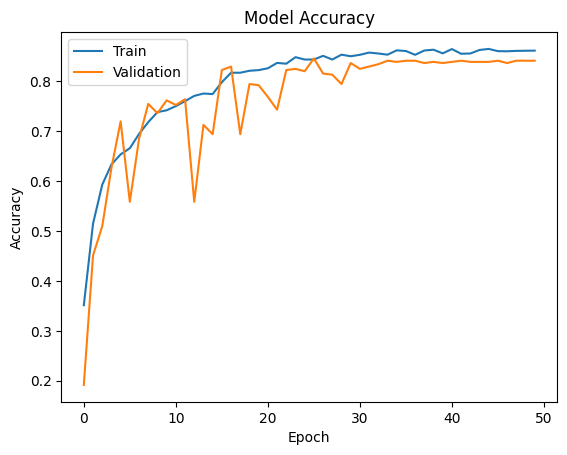

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* This model's performance has significantly improve over our previous model's performance
  * The training accuracy is .86, and the validation accuracy is .84
  * Our model is generalizing the data much better and is no longer overfitting

In [ ]:
accuracy_2 = model_2.evaluate(X_test_norm, y_test_enc, verbose=2)

15/15 - 0s - loss: 0.5365 - accuracy: 0.8211 - 77ms/epoch - 5ms/step


* The accuracy on the test dataset is right where we expect it to be, coming in at .82

In [ ]:
y_pred=model_2.predict(X_test_norm)

15/15 [==============================] - 0s 3ms/step


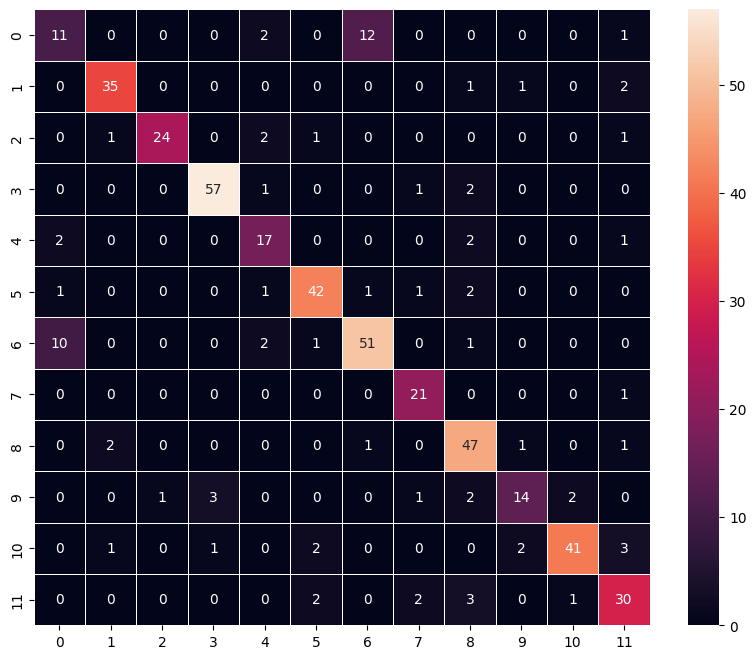

In [ ]:
y_pred_arg=np.argmax(y_pred, axis=1)
y_test_arg=np.argmax(y_test_enc, axis=1)

confusion_matrix=tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt='d',
    square=True,
    ax=ax
)
plt.show()

* This model is able to correctly classify more of the images
  * Originally there were 18 images in class 6 that were misclassified, this improved model has brought that number down to 12

In [ ]:
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
for layer in vgg_model.layers:
  layer.trainable=False

In [ ]:
model_3 = Sequential()

model_3.add(vgg_model)

model_3.add(Flatten())

model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.3))
model_3.add(BatchNormalization())

model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(0.3))

model_3.add(Dense(12, activation='softmax'))

opt=Adam()

model_3.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [ ]:
history_3 = model_3.fit(train_datagen.flow(
    X_train_norm,
    y_train_enc,
    batch_size=64,
    shuffle=False),
                        epochs=50,
                        steps_per_epoch=X_train_norm.shape[0]//64,
                        validation_data=(X_val_norm, y_val_enc),
                        callbacks=[learning_rate_reduction],
                        verbose=2
)

Epoch 1/50
60/60 - 14s - loss: 2.4284 - accuracy: 0.1568 - val_loss: 2.2249 - val_accuracy: 0.2850 - lr: 0.0010 - 14s/epoch - 236ms/step
Epoch 2/50
60/60 - 5s - loss: 2.0944 - accuracy: 0.2807 - val_loss: 1.9660 - val_accuracy: 0.4206 - lr: 0.0010 - 5s/epoch - 91ms/step
Epoch 3/50
60/60 - 7s - loss: 1.9369 - accuracy: 0.3214 - val_loss: 1.8329 - val_accuracy: 0.4065 - lr: 0.0010 - 7s/epoch - 117ms/step
Epoch 4/50
60/60 - 5s - loss: 1.8221 - accuracy: 0.3656 - val_loss: 1.6591 - val_accuracy: 0.4720 - lr: 0.0010 - 5s/epoch - 89ms/step
Epoch 5/50
60/60 - 6s - loss: 1.7520 - accuracy: 0.3801 - val_loss: 1.5902 - val_accuracy: 0.4907 - lr: 0.0010 - 6s/epoch - 95ms/step
Epoch 6/50
60/60 - 7s - loss: 1.6941 - accuracy: 0.3978 - val_loss: 1.5395 - val_accuracy: 0.4696 - lr: 0.0010 - 7s/epoch - 112ms/step
Epoch 7/50
60/60 - 5s - loss: 1.6519 - accuracy: 0.4029 - val_loss: 1.5277 - val_accuracy: 0.4743 - lr: 0.0010 - 5s/epoch - 87ms/step
Epoch 8/50
60/60 - 7s - loss: 1.5978 - accuracy: 0.4370 -

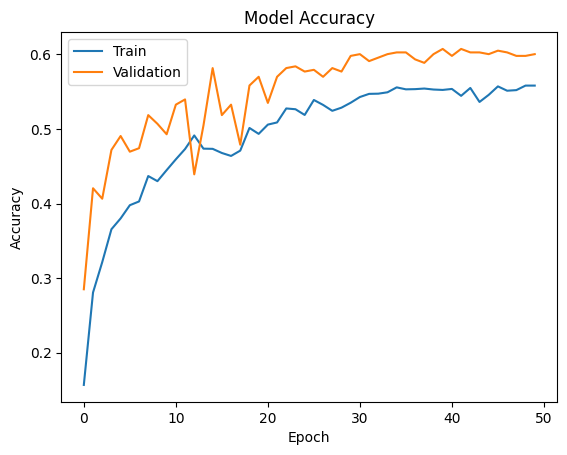

In [ ]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy_3 = model_3.evaluate(X_test_norm, y_test_enc, verbose=2)

15/15 - 1s - loss: 1.1728 - accuracy: 0.6000 - 1s/epoch - 82ms/step


In [ ]:
y_pred=model_3.predict(X_test_norm)

15/15 [==============================] - 0s 13ms/step


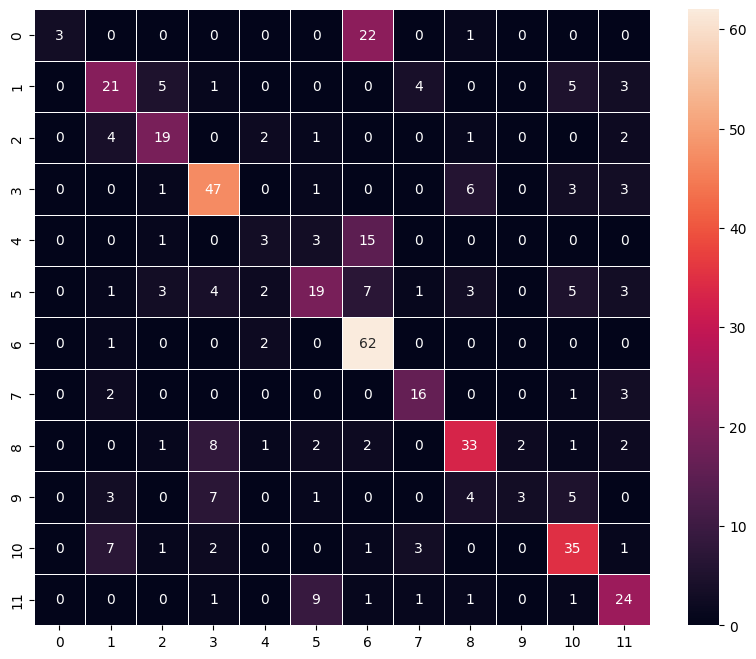

In [ ]:
y_pred_arg=np.argmax(y_pred, axis=1)
y_test_arg=np.argmax(y_test_enc, axis=1)

confusion_matrix=tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt='d',
    square=True,
    ax=ax
)
plt.show()

* The 3rd model was built using the VGG16 model including the weights from the imagenet dataset
  * This model did not perform well on our dataset

## Final Model

In [ ]:
model_comparison = pd.DataFrame(
    [accuracy_1, accuracy_2, accuracy_3],
    columns = ['Loss', 'Accuracy'],
    index=['Model_1', 'Model_2', 'Model_3']
)

model_comparison

,Loss,Accuracy
Model_1,1.724763,0.690526
Model_2,0.536521,0.821053
Model_3,1.172801,0.600000


* According to the accurancy curve and confusion matrix. Model 2 (Dropout, BatchNormalization, and Learning Rate Monitoring) had the highest performance metrics from out 3 models
  * The accuracy of Model_2 is .82 on the testing data set

### Visualizing the prediction

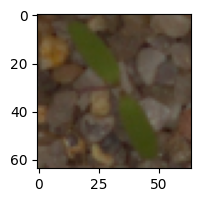

1/1 [==============================] - 0s 117ms/step
Predicted Label ['Fat Hen']
True Label Fat Hen


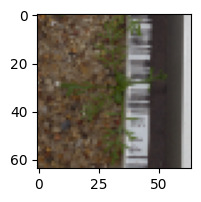

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Scentless Mayweed']
True Label Scentless Mayweed


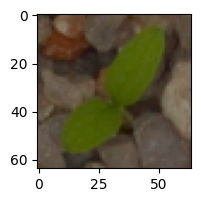

1/1 [==============================] - 0s 22ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_2.predict((X_test_norm[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_enc)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[35])
plt.show()
print('Predicted Label', enc.inverse_transform(model_2.predict((X_test_norm[35].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_enc)[35])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[53])
plt.show()
print('Predicted Label', enc.inverse_transform(model_2.predict((X_test_norm[53].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_enc)[53])

## Actionable Insights and Business Recommendations

* We can observe from the confusion matrix of each model that Model_2 was able to correctly classify the images in our 12 classes with the highest accuracy
  * The test accuracy of Model_2 was 82%
* Data Augmentation helped fix the class imbalance due to the differing number of images within each class
  * Further Data Augmentation paramenters could be experimented with to further increase the model's accuracy
* To further improve this model, the model could be trained on the original sized image; however, it will be more computational expensive
* The most commonly misclassified images were those in classes 0 (Black Grass) and 6 (Loose Silky Bent)
* Images sorted in these class may need addition identification proceedures


_____